## Aprendizaje de reglas de asociación

Objetivo:
    
    derivar reglas de la forma {A} -> {B}
    

In [1]:
%pylab inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display

#!pip install efficient_apriori

Populating the interactive namespace from numpy and matplotlib


In [2]:
def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))

In [3]:
movies = pd.read_csv('data/ml-20m/movies.csv',sep=",")

print('orders -- dimensions: {0};   size: {1}'.format(movies.shape, size(movies)))
display(movies.head())
display(movies.tail())

orders -- dimensions: (27278, 3);   size: 4.50 MB


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,title,genres
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)
27277,131262,Innocence (2014),Adventure|Fantasy|Horror


In [4]:
new = movies["title"].str.rsplit("(",n=1,expand=True)

In [5]:
movies["year"] = new[1].str.replace(")","")
movies["Title"] = new[0]

In [6]:
movies["year"] = movies["year"].str.rstrip()

In [7]:
is_digit = movies["year"].str.isdigit()

In [8]:
movies.loc[movies.index[movies["year"].str.isdigit() == False]]

,movieId,title,genres,year,Title
15646,79607,"Millions Game, The (Das Millionenspiel)",Action|Drama|Sci-Fi|Thriller,Das Millionenspiel,"Millions Game, The"
17341,87442,"Bicycle, Spoon, Apple (Bicicleta, cullera, poma)",Documentary,"Bicicleta, cullera, poma","Bicycle, Spoon, Apple"
22368,107434,Diplomatic Immunity (2009– ),Comedy,2009–,Diplomatic Immunity
22669,108548,"Big Bang Theory, The (2007-)",Comedy,2007-,"Big Bang Theory, The"
22679,108583,Fawlty Towers (1975-1979),Comedy,1975-1979,Fawlty Towers


In [9]:
movies.loc[15646,"year"] = "1970"
movies.loc[17341,"year"] = "2010"
movies.loc[22368,"year"] = "2009"
movies.loc[22669,"year"] = "2007"
movies.loc[22679,"year"] = "1979"

In [10]:
year_is_na = movies["year"].isna()
print(year_is_na.sum())

17


In [11]:
movies.loc[movies.index[year_is_na]]

,movieId,title,genres,year,Title
10593,40697,Babylon 5,Sci-Fi,None,Babylon 5
23617,112406,Brazil: In the Shadow of the Stadiums,Documentary,None,Brazil: In the Shadow of the Stadiums
23824,113190,Slaying the Badger,Documentary,None,Slaying the Badger
24286,115133,Tatort: Im Schmerz geboren,Crime,None,Tatort: Im Schmerz geboren
24412,115685,National Theatre Live: Frankenstein,Drama|Fantasy,None,National Theatre Live: Frankenstein
26115,125571,The Court-Martial of Jackie Robinson,(no genres listed),None,The Court-Martial of Jackie Robinson
26127,125632,In Our Garden,(no genres listed),None,In Our Garden
26180,125958,Stephen Fry In America - New World,(no genres listed),None,Stephen Fry In America - New World
26335,126438,Two: The Story of Roman & Nyro,Documentary|Drama,None,Two: The Story of Roman & Nyro
26395,126929,Li'l Quinquin,(no genres listed),None,Li'l Quinquin


In [12]:
movies.loc[movies.index[year_is_na],"year"] = "1900"

In [13]:
movies["year"] = movies["year"].astype("int32")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbabd236c50>]],
      dtype=object)

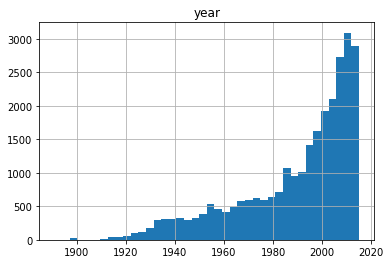

In [14]:
movies.hist(bins=40,column="year")

In [15]:
a = movies["genres"].str.cat(sep='|').split("|")
np.unique(a)

array(['(no genres listed)', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'], dtype='<U18')

In [16]:
index = movies["genres"] == "(no genres listed)"
print(index.sum())

246


In [17]:
generos = movies["genres"].str.split("|")
generos.head()

0    [Adventure, Animation, Children, Comedy, Fantasy]
1                       [Adventure, Children, Fantasy]
2                                    [Comedy, Romance]
3                             [Comedy, Drama, Romance]
4                                             [Comedy]
Name: genres, dtype: object

In [18]:
#Funcion para pasar titulos del tipo "Big Bang Theory, The" a "The Big Bang Theory"

def swap_the(string):
    i = string.find(", The")
    s = string.rstrip()
    if i != -1:
        s = string[:i]
        s = "The " + s
    return(s)

In [19]:
movies["Title"] = movies["Title"].apply(swap_the)

Cargamos la base de datos con el ratings de los usuarios

In [20]:
ratings = pd.read_csv('data/ml-20m/ratings.csv',sep=",",usecols=["userId","movieId","rating"])

print('orders -- dimensions: {0};   size: {1}'.format(ratings.shape, size(ratings)))
display(ratings.head())
display(ratings.tail())

orders -- dimensions: (20000263, 3);   size: 480.01 MB


,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


,userId,movieId,rating
20000258,138493,68954,4.5
20000259,138493,69526,4.5
20000260,138493,69644,3.0
20000261,138493,70286,5.0
20000262,138493,71619,2.5


Chequeo que dentro de la base de datos _ratings_ no haya peliculas que no estén listadas en la base de datos _movies_

In [21]:
ratings.index[~ratings["movieId"].isin(movies["movieId"])].size

0

In [22]:
ratings.drop(index=ratings.index[ratings["rating"] < 4],inplace=True)
print('orders -- dimensions: {0};   size: {1}'.format(ratings.shape, size(ratings)))

orders -- dimensions: (9995410, 3);   size: 319.85 MB


Defino un diccionario que utilizaré luego para imprimir las reglas con los titulos de las películas

In [23]:
rename_dict = movies.set_index('movieId').to_dict()['Title']

In [24]:
#ratings["movieId"] = ratings["movieId"].replace(rename_dict)

In [25]:
print(ratings["userId"].unique().shape)
print(ratings["movieId"].unique().shape)

(138287,)
(20720,)


In [26]:
a = ratings.groupby('userId')

In [27]:
i = a.size()

In [28]:
m = 2000
n = np.sum(i.iloc[0:m])
print(ratings['userId'].iloc[n:n+i.iloc[m]].unique())

[2004]


Creo la lista de transacciones, aprovecho que la base de datos está ordenada por el ID del usuario.

In [30]:
transactions = []
j = 0
for k in range(i.shape[0]):
    transactions.append(np.array(ratings['movieId'].iloc[j:j+i.iloc[k]]))
    j += i.iloc[k]

**NOTA:** en caso de no tener el archivo .pickle descomentar las siguientes celdas y ejecutarlas. Subir el parámetro min_support para que no demore tanto

In [ ]:
#from efficient_apriori import apriori
#itemsets, rules = apriori(transactions,min_support=0.005,min_confidence=0.2,max_length=2,verbosity=1)

In [ ]:
#a = rules[0]

In [ ]:
#a.confidence,a.conviction,a.count_full,a.count_lhs,a.count_rhs,a.lhs,a.lift,a.num_transactions,a.rhs,a.support

In [34]:
import pickle

In [ ]:
#f = open("rules_sup_0.005_conf_0.2.pickle","wb")i#
#pickle.dump(rules,f)
#f.close()

Cargo el archivo con las reglas guardadas, fueron computadas tomando los parámetros min_support = 0.005 y min_confidence = 0.2

In [35]:
f = open("rules_sup_0.005_conf_0.2.pickle","rb")
rules = pickle.load(f)
f.close()

### Confianza

Primeras 10 reglas ordenadas según el valor de la confianza, de mayor a menor

In [36]:
rules=sorted(rules, key=lambda rule: rule.confidence,reverse=True)

In [37]:
for item in rules[:10]:
    print("Rule: " + str(rename_dict[item.lhs[0]]) + " -> " + str(rename_dict[item.rhs[0]]))

    print("Support: " + str(item.support))
    print("Confidence: " + str(item.confidence))
    print("Lift: " + str(item.lift))
    print("Conviction: " + str(item.conviction))
    print("=====================================")

Rule: The Matrix Revolutions -> The Matrix
Support: 0.02655347212680874
Confidence: 0.9145703611457036
Lift: 3.148997622980253
Conviction: 8.305873513623167
Rule: The Godfather: Part II -> The Godfather
Support: 0.1464562829477825
Confidence: 0.9071079858467327
Lift: 3.6023560403993775
Conviction: 8.054409805835297
Rule: The Matrix Reloaded -> The Matrix
Support: 0.041218625033444936
Confidence: 0.9001895135818067
Lift: 3.0994822912802156
Conviction: 7.109150564220445
Rule: The Animatrix -> The Matrix
Support: 0.00928503763911286
Confidence: 0.8873531444367657
Lift: 3.0552848214706825
Conviction: 6.299046458929382
Rule: Following -> Memento
Support: 0.005076399083066376
Confidence: 0.8808030112923463
Lift: 5.087444909472253
Conviction: 6.936981497704612
Rule: Monty Python Live at the Hollywood Bowl -> Monty Python and the Holy Grail
Support: 0.010630066455993695
Confidence: 0.8734402852049911
Lift: 4.659392690666305
Conviction: 6.42022642865773
Rule: Pirates of the Caribbean: At World'

### Lift

Primeras 10 reglas ordenadas según el valor de lift, de mayor a menor

In [38]:
rules=sorted(rules, key=lambda rule: rule.lift,reverse=True)

In [39]:
for item in rules[:10]:
    print("Rule: " + str(rename_dict[item.lhs[0]]) + " -> " + str(rename_dict[item.rhs[0]]))

    print("Support: " + str(item.support))
    print("Confidence: " + str(item.confidence))
    print("Lift: " + str(item.lift))
    print("Conviction: " + str(item.conviction))
    print("=====================================")

Rule: Planet Terror -> Grindhouse
Support: 0.005900771583735275
Confidence: 0.6425196850393701
Lift: 42.37106327374315
Conviction: 2.754937379261994
Rule: Grindhouse -> Planet Terror
Support: 0.005900771583735275
Confidence: 0.38912732474964234
Lift: 42.37106327374315
Conviction: 1.6219684389402402
Rule: Dracula -> Frankenstein
Support: 0.005813995531033286
Confidence: 0.6437149719775821
Lift: 40.88994594849053
Conviction: 2.7625560930049162
Rule: Frankenstein -> Dracula
Support: 0.005813995531033286
Confidence: 0.36931557188791914
Lift: 40.88994594849053
Conviction: 1.5712581656350992
Rule: Manon of the Spring (Manon des sources) -> Jean de Florette
Support: 0.012286042795056658
Confidence: 0.7266894781864842
Lift: 39.735748465786614
Conviction: 3.591928831671416
Rule: Jean de Florette -> Manon of the Spring (Manon des sources)
Support: 0.012286042795056658
Confidence: 0.671807038355081
Lift: 39.735748465786614
Conviction: 2.9954729207956783
Rule: The Man with the Golden Gun -> The Sp

### Convicción

Primeras 10 reglas ordenadas según el valor de la convicción, de mayor a menor

In [42]:
rules=sorted(rules, key=lambda rule: rule.conviction,reverse=True)

In [43]:
for item in rules[:10]:
    print("Rule: " + str(rename_dict[item.lhs[0]]) + " -> " + str(rename_dict[item.rhs[0]]))

    print("Support: " + str(item.support))
    print("Confidence: " + str(item.confidence))
    print("Lift: " + str(item.lift))
    print("Conviction: " + str(item.conviction))
    print("=====================================")

Rule: The Matrix Revolutions -> The Matrix
Support: 0.02655347212680874
Confidence: 0.9145703611457036
Lift: 3.148997622980253
Conviction: 8.305873513623167
Rule: The Godfather: Part II -> The Godfather
Support: 0.1464562829477825
Confidence: 0.9071079858467327
Lift: 3.6023560403993775
Conviction: 8.054409805835297
Rule: The Matrix Reloaded -> The Matrix
Support: 0.041218625033444936
Confidence: 0.9001895135818067
Lift: 3.0994822912802156
Conviction: 7.109150564220445
Rule: Following -> Memento
Support: 0.005076399083066376
Confidence: 0.8808030112923463
Lift: 5.087444909472253
Conviction: 6.936981497704612
Rule: Pirates of the Caribbean: At World's End -> Pirates of the Caribbean: The Curse of the Black Pearl
Support: 0.01379016104189114
Confidence: 0.8711740520785747
Lift: 7.582103728352311
Conviction: 6.870520126536695
Rule: Porco Rosso (Crimson Pig) (Kurenai no buta) -> Spirited Away (Sen to Chihiro no kamikakushi)
Support: 0.007426583843745255
Confidence: 0.8594142259414226
Lift: 

### Soporte

Primeras 10 reglas ordenadas según el valor del soporte, de mayor a menor

In [44]:
rules=sorted(rules, key=lambda rule: rule.support,reverse=True)

In [46]:
for item in rules[:10]:
    print("Rule: " + str(rename_dict[item.lhs[0]]) + " -> " + str(rename_dict[item.rhs[0]]))

    print("Support: " + str(item.support))
    print("Confidence: " + str(item.confidence))
    print("Lift: " + str(item.lift))
    print("Conviction: " + str(item.conviction))
    print("=====================================")

Rule: Pulp Fiction -> The Shawshank Redemption
Support: 0.23441827503669904
Confidence: 0.6192004278646878
Lift: 1.5343481923078484
Conviction: 1.5662852000092338
Rule: The Shawshank Redemption -> Pulp Fiction
Support: 0.23441827503669904
Confidence: 0.5808769509201355
Lift: 1.5343481923078484
Conviction: 1.482661895965836
Rule: The Silence of the Lambs -> The Shawshank Redemption
Support: 0.2280257724876525
Confidence: 0.6292253661651435
Lift: 1.5591894961363126
Conviction: 1.6086341392725767
Rule: The Shawshank Redemption -> The Silence of the Lambs
Support: 0.2280257724876525
Confidence: 0.5650366441485835
Lift: 1.5591894961363126
Conviction: 1.465890703659548
Rule: The Silence of the Lambs -> Pulp Fiction
Support: 0.2279389964349505
Confidence: 0.6289859121203656
Lift: 1.661424843454797
Conviction: 1.6749169228341576
Rule: Pulp Fiction -> The Silence of the Lambs
Support: 0.2279389964349505
Confidence: 0.6020858403529884
Lift: 1.661424843454797
Conviction: 1.6023776087895067
Rule: 

Puede observarse que las primeras 5 reglas cambiar según el parámetro por el cuál es las ordene.
Se observa que cuando se ordenan por confianza o convicción, las reglas obtenidas son más "obvias" que las ordenadas por otros parámetros.
Las reglas con Lift grandes tiene, por lo general soporte muy bajo, casi en el límite establecido de 0.0005.